## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import mode
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    """
    default weights in sklearn - uniform
    default metric in sklearn - euclidean
    """
    
    def __init__(self, n_neighbors, algorithm='brute', metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X.copy()
        self.y_train = y.copy()
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(self.X_train, leaf_size=2)
    
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X_train, metric=self.metric)
            distances_indexes =  distances.argsort()[:, :self.n_neighbors] # check args for argsort
        elif self.algorithm == 'kd_tree':
            distances, distances_indexes = self.tree.query(X, k=self.n_neighbors)
        else:
            raise "wrong algorithm"
        # print(distances_indexes)
        neighbors_y = self.y_train[distances_indexes].reshape((-1, self.n_neighbors))
        # print(neighbors_y)
        # unique_neighbors = list(map(lambda x: np.unique(x, return_counts=True), neighbors_y))
        ans = mode(neighbors_y, axis=1)
        # print(ans)
        return ans[0].ravel()
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 1.07 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 45 µs, sys: 17 µs, total: 62 µs
Wall time: 68.9 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 4.77 ms, sys: 293 µs, total: 5.06 ms
Wall time: 4.21 ms


array([0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 4.75 ms, sys: 284 µs, total: 5.04 ms
Wall time: 4.19 ms


array([0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 1.32 ms, sys: 511 µs, total: 1.83 ms
Wall time: 1.88 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 334 µs, sys: 129 µs, total: 463 µs
Wall time: 365 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 2.82 ms


array([0, 1, 2, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 2])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 1.51 ms, sys: 3.06 ms, total: 4.57 ms
Wall time: 3.6 ms


array([0, 1, 2, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 2])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

 ## может имелось ввиду cross_val_score?

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
cv_scores = []
best_score = 0
best_model = None
for i in range(1, 11):
    clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute')
    scores = cross_val_score(clf, data_vectorized, target, cv=3, scoring='accuracy')
    print(scores)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)
    if mean_score > best_score:
        best_score = mean_score
        best_model = clf

[0.20705196 0.2094935  0.20896314]
[0.19034995 0.19066561 0.18164943]
[0.18319194 0.1864227  0.18430125]
[0.17682927 0.18297534 0.18297534]
[0.18027572 0.18297534 0.18695306]
[0.17868505 0.18377088 0.1864227 ]
[0.18107105 0.18880933 0.18509679]
[0.1821315  0.18880933 0.18854415]
[0.18478261 0.19172633 0.19172633]
[0.18849417 0.18880933 0.19676478]


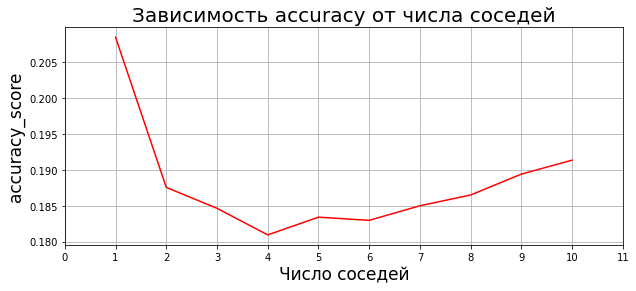

In [24]:
plt.figure(figsize=(10,4))
plt.title('Зависимость accuracy от числа соседей', fontsize=20)
plt.plot([i for i in range(1, 11)], cv_scores, color='r')
plt.grid(True) 
plt.xticks(range(0, 12))
plt.ylabel('accuracy_score',  fontsize=17)
plt.xlabel('Число соседей',  fontsize=17)

plt.show()

In [25]:
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(data)
tf_data_vectorized = vectorizer.transform(data)

In [26]:
tf_cv_scores = []
tf_best_score = 0
tf_best_model = None
for i in range(1, 11):
    clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute', metric="cosine")
    scores = cross_val_score(clf, tf_data_vectorized, target, cv=3, scoring='accuracy')
    print(scores)
    mean_score = np.mean(scores)
    tf_cv_scores.append(mean_score)
    if mean_score > tf_best_score:
        tf_best_score = mean_score
        tf_best_model = clf

[0.29533404 0.28692654 0.29488199]
[0.28181336 0.2643861  0.26995492]
[0.27704136 0.25510475 0.27393264]
[0.27439024 0.24900557 0.27287192]
[0.26617179 0.25033148 0.27128083]
[0.26086957 0.24635375 0.2673031 ]
[0.26219512 0.24608857 0.26571201]
[0.25821845 0.24211085 0.26624238]
[0.25609756 0.24025457 0.26252983]
[0.24787911 0.23733758 0.25616547]


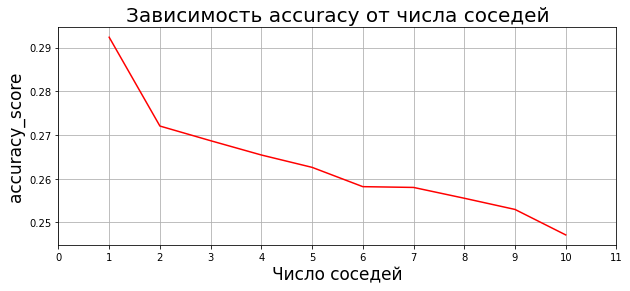

In [27]:
plt.figure(figsize=(10,4))
plt.title('Зависимость accuracy от числа соседей', fontsize=20)
plt.plot([i for i in range(1, 11)], tf_cv_scores, color='r')
plt.grid(True) 
plt.xticks(range(0, 12))
plt.ylabel('accuracy_score',  fontsize=17)
plt.xlabel('Число соседей',  fontsize=17)

plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [28]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [29]:
test_data = newsgroups["data"]
test_target = newsgroups["target"]

In [30]:
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(test_data)
test_tf_data_vectorized = tf_vectorizer.transform(test_data)
train_tf_data_vectorized = tf_vectorizer.transform(data)

In [31]:
best_model = MyKNeighborsClassifier(n_neighbors=1,algorithm='brute', metric="cosine")
best_model.fit(train_tf_data_vectorized, target)
best_predict = best_model.predict(test_tf_data_vectorized)

In [32]:
accuracy_score(test_target, best_predict)

0.50570897503983

In [33]:
train_tf_data_vectorized.shape

(11314, 71018)

## Качество увеличилось из-за увеличения тренировочной выборки в 3 раза, что при сравнимых размерностях пространства признаков очень сильно повлияло из-за проклятия размерности